# Comparison of Word2Vec, GloVe and FastText for measuring semantic similarity between pairs of sentences
## Pablo Valdunciel 


## Models

Use the *KeyedVectors* model from the [*gesim*](https://radimrehurek.com/gensim/index.html) library to load the pre-trained vectors/embeddings of the different models. 

In [2]:
from gensim.models import KeyedVectors 

Load the pre-trained vectors with Word2Vec, GloVe and FastText models. The pre-trained vectors of each model are:

|  Model | Source | Vocabulary size | Vector dimension | Language |
|:--------:|:-----------------------:|:-----------:|:-------------------------:|:------:|
| **Word2Vec** |     [GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)                      |   3 million          |            300            | EN |
|   **GloVe**  |[Common  Crawl  (840B  tokens,2.2M vocab, cased, 300d vectors)](http://nlp.stanford.edu/data/glove.840B.300d.zip)|     2,2 million        |            300            | EN |
| **FastText** |  [rawl-300d-2M.vec.zip:  2  million  word  vectors  trained  on  Common  Crawl  (600Btokens)](https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip)                       |  2 million           |            300            | EN |

In the case of GloVe vectors, the function [*glove2word2vec*](https://radimrehurek.com/gensim/scripts/glove2word2vec.html) from the *gensim* library has been used to convert the file to Word2Vec format.

In [2]:
PATH_WORD2VEC = './data/embedding/word2vec/GoogleNews-vectors-negative300.bin'
PATH_GLOVE = './data/embedding/glove/glove.840B.300d.w2v.txt'
PATH_FASTTEXT = './data/embedding/fasttext/crawl-300d-2M.vec'

Load the three vector sets (this might take a few minutes to complete).

In [3]:
word2vec = KeyedVectors.load_word2vec_format(PATH_WORD2VEC, binary=True)

In [4]:
glove = KeyedVectors.load_word2vec_format(PATH_GLOVE, binary=False)

In [5]:
fasttext = KeyedVectors.load_word2vec_format(PATH_FASTTEXT, binary=False)

## Data

Using the functions of the *load.py* module, we load the **test** sets of the STS12, STS13, STS14, STS15, STS16 and SICK-R tasks.

| Corpus | # of instances|                                        Source                                         |
|:------:|:----------:|:------------------------------------------------------------------------------------------:|
|  STS12 | 3108 |                      [SemEval 2012 - STS](https://www.cs.york.ac.uk/semeval-2012/task6/)                       |
|  STS13 | 1500 |                               [SemEval 2013 - STS](http://ixa2.si.ehu.es/sts/)                                |
|  STS14 | 3750 |               [SemEval 2014 - STS](http://alt.qcri.org/semeval2014/task10/index.php?id=sts-en)                |
|  STS15 | 3000| [SemEval 2015 - STS](http://alt.qcri.org/semeval2015/task2/index.php?id=semantic-textual-similarity-for-english) |
|  STS16 |  1186|                         [SemEval 2016 - STS](http://alt.qcri.org/semeval2016/task1/)                           |
| SICK-R | 9927 |[SICK Relatedness](https://zenodo.org/record/2787612#.Xlf59XVKhhE) |

All functions in the *load.py* module perform sentence preprocessing according to the parameters you specify. By default, sentence preprocessing is based on *tokenisation/segmentation* of sentences. In addition, there are the following possibilities:

- `lowercase`: make all words lowercase.
- `stop_words`: remove words that have almost no semantic meaning, such as determiners, preprositions, etc.
- `punctuation`: remove punctuation symbols.
- `only_ascci`: remove words that do not consist of ASCII characters.
- `lemmatization`: replace words with their lexemes.

Text preprocessing is implemented in the *preprocess* function in the *utils.py* module. The *preprocess* function makes use of the [spaCy](https://spacy.io/) library to perform the preprocessing.

In [3]:
from load import load_sts_12, load_sts_13, load_sts_14, load_sts_15, load_sts_16, load_SICK
from load import load_frequencies

In this case, only the *tokenisation/segmentation* of the sentences and a conversion to lowercase is performed to achieve uniformity.

In [1]:
PATH_STS = './data/datasets/STS'
PATH_SICK = './data/datasets/SICK'
PATH_FREQUENCIES = './data/frequencies.tsv'
PREPROCESSING =  {'lowercase':  True, 
                  'stop_words': False, 
                  'punctuation': False, 
                  'only_ascii': False, 
                  'lemmatization': False
                 }

Load also the frequencies of the words in the corpus in order to be able to apply the SIF average.

In [3]:
freqs = load_frequencies(PATH_FREQUENCIES)

In [4]:
sts12 = load_sts_12(PATH_STS, PREPROCESSING, verbose=True)
sts13 = load_sts_13(PATH_STS, PREPROCESSING, verbose=True)
sts14 = load_sts_14(PATH_STS, PREPROCESSING, verbose=True)
sts15 = load_sts_15(PATH_STS, PREPROCESSING, verbose=True)
sts16 = load_sts_16(PATH_STS, PREPROCESSING, verbose=True)
sick = load_SICK(PATH_SICK, PREPROCESSING, verbose=True)



***** TASK: STS12 *****

Preprocessing -MSRpar-
-MSRpar- preprocessed correctly
Preprocessing -MSRvid-
-MSRvid- preprocessed correctly
Preprocessing -SMTeuroparl-
-SMTeuroparl- preprocessed correctly
Preprocessing -surprise.OnWN-
-surprise.OnWN- preprocessed correctly
Preprocessing -surprise.SMTnews-
-surprise.SMTnews- preprocessed correctly


***** TASK: STS13 (-SMT) ***

Preprocessing -FNWN-
-FNWN- preprocessed correctly
Preprocessing -headlines-
-headlines- preprocessed correctly
Preprocessing -OnWN-
-OnWN- preprocessed correctly


***** TASK: STS14 *****

Preprocessing -deft-forum-
-deft-forum- preprocessed correctly
Preprocessing -deft-news-
-deft-news- preprocessed correctly
Preprocessing -headlines-
-headlines- preprocessed correctly
Preprocessing -images-
-images- preprocessed correctly
Preprocessing -OnWN-
-OnWN- preprocessed correctly
Preprocessing -tweet-news-
-tweet-news- preprocessed correctly


***** TASK: STS15 *****

Preprocessing -answers-forums-
-answers-forums- pre

## Methods

The methods for calculating the semantic similarity between two sentences are found in the *methods.py* module and are as follows:

- `avg_cosine`: the vector of a sentence is obtained by averaging the vectors of the words in that sentence. The similarity between two vectors is calculated using cosine similarity.
- `sif_cosine`: the vector of a sentence is obtained by taking a weighted average (*Smooth Inverse Frequency*, SIF) of the vectors of the words in that sentence. The similarity between two vectors is calculated using cosine similarity.
- `wmd`: the similarity between two sentences is calculated as the inverse of the *Word Mover's Distance* between them. The *KeyedVectors* model of *gensim* incorporates the calculation of this distance ([see method](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.wmdistance)). This distance is not bounded and will take the value *infinite* when none of the words of any of the two sentences is present in the model, so it has been bounded in the interval [0, 100].

In [4]:
from functools import partial
from methods import avg_cosine, wmd, sif_cosine

In [15]:
METHODS = [
    ("W2V + AVG", partial(avg_cosine, model=word2vec)),
    ("W2V + SIF", partial(sif_cosine, model=word2vec, frequencies=freqs, a=0.001)),
    ("W2V + WMD", partial(wmd, model=word2vec)),   
    ("GLOVE + AVG", partial(avg_cosine, model=glove)),
    ("GLOVE + SIF", partial(sif_cosine, model=glove, frequencies=freqs, a=0.001)),
    ("GLOVE + WMD", partial(wmd, model=glove)),    
    ("FT + AVG", partial(avg_cosine, model=fasttext)),
    ("FT + SIF", partial(sif_cosine, model=fasttext, frequencies=freqs, a=0.001)),
    ("FT + WMD", partial(wmd, model=fasttext))    
]

## Evaluation

The `utils` module contains the `evaluate` function that calculates the Pearson and Spearman correlation coefficients between the *Gold Standard* scores of a task and the similarity measures provided by one or more methods.

In [6]:
from utils import evaluate
from scipy.stats import rankdata, chi2
from Orange.evaluation import compute_CD, graph_ranks
import numpy as np
import pprint
import matplotlib.pyplot as plt

In [18]:
N = 6  # Number of corpus
K = 9  # Number of methods

In [22]:
sts12_pearson, sts12_spearman = evaluate(sts12, METHODS)
sts13_pearson, sts13_spearman = evaluate(sts13, METHODS)
sts14_pearson, sts14_spearman = evaluate(sts14, METHODS)
sts15_pearson, sts15_spearman = evaluate(sts15, METHODS)
sts16_pearson, sts16_spearman = evaluate(sts16, METHODS)
sick_pearson, sick_spearman = evaluate(sick, METHODS)

### Pearson correlation coefficients

In the following table we can observe the Pearson correlation coefficients obtained by each of the methods on each corpus.

In [32]:
pearson_corr = np.array([ np.array(list(sts12_pearson.values())), 
                          np.array(list(sts13_pearson.values())),
                          np.array(list(sts14_pearson.values())),
                          np.array(list(sts15_pearson.values())),
                          np.array(list(sts16_pearson.values())),
                          np.array(list(sick_pearson.values()))
                        ])

| Corpus | W2V  +  AVG | W2V  +  SIF | W2V  +  WMD | GLOVE  +  AVG | GLOVE + SIF | GLOVE  +  WMD | FT  +  AVG | FT  +  SIF | FT  +  WMD |
|:---------------:|:-----------:|:-----------:|:-----------:|:-------------:|:-----------:|:-------------:|:----------:|:----------:|:----------:|
|      STS12      |    0,5577   |    0,5670   |    0,4735   |     0,5503    |    0,5887   |     0,5511    |   0,6006   |   0,6213   |   0,5535   |
|      STS13      |    0,6402   |    0,7227   |    0,5212   |     0,5431    |    0,7004   |     0,4865    |   0,6396   |   0,7431   |   0,5043   |
|      STS14      |    0,6868   |    0,7279   |    0,6122   |     0,5625    |    0,7069   |     0,5803    |   0,6664   |   0,7356   |   0,5921   |
|      STS15      |    0,7049   |    0,7490   |    0,6839   |     0,6006    |    0,7319   |     0,6796    |   0,6999   |   0,7613   |   0,6888   |
|      STS16      |    0,6391   |    0,7191   |    0,6408   |     0,5025    |    0,6847   |     0,6133    |   0,6326   |   0,7315   |   0,6312   |
|      SICK-R     |    0,7012   |    0,7318   |    0,6125   |     0,6517    |    0,7215   |     0,5995    |   0,6980   |   0,7400   |   0,6045   |

### Rankings 


Calculate the average rankin for each corpus.

In [35]:
ranks = np.array([np.array(rankdata((-1)*pearson_corr[task])) for task in range(pearson_corr.shape[0])])
avg_ranks = np.average(ranks, axis=0)

| Corpus \ Método | W2V  +  AVG | W2V  +  SIF | W2V  +  WMD | GLOVE  +  AVG | GLOVE + SIF | GLOVE  +  WMD | FT  +  AVG | FT  +  SIF | FT  +  WMD |
|:---------------:|:-----------:|:-----------:|:-----------:|:-------------:|:-----------:|:-------------:|:----------:|:----------:|:----------:|
|      STS12      |      5      |      4      |      9      |       8       |      3      |       7       |      2     |      1     |      6     |
|      STS13      |      4      |      2      |      7      |       6       |      3      |       9       |      5     |      1     |      8     |
|      STS14      |      4      |      2      |      6      |       9       |      3      |       8       |      5     |      1     |      7     |
|      STS15      |      4      |      2      |      7      |       9       |      3      |       8       |      5     |      1     |      6     |
|      STS16      |      5      |      2      |      4      |       9       |      3      |       8       |      6     |      1     |      7     |
|      SICK-R     |      4      |      2      |      7      |       6       |      3      |       9       |      5     |      1     |      8     |
|       |       |      |      |          |        |           |       |         |       |
|     Average    |     4,33    |     2,33    |     6,67    |      7,83     |     3,00    |      8,17     |    4,67    |    1,00    |    7,00    |

### Friedman test

Hypothesis test:

- H<sub>0</sub>: all the metods are equivalent
- H<sub>1</sub>: not all the methods are equivalent

To solve this hypothesis test, the Friedman test on the average rankings is performed. Even without performing the test, these average rankings already provide a good comparison of the different methods.


    
| Position | Average ranking |    Method   |
|:--------:|:----------------:|:-----------:|
|     1    |         1        |   FT + SIF  |
|     2    |       2,33       |  W2V + SIF  |
|     3    |         3        | GLOVE + SIF |
|     4    |       4,33       |  W2V + AVG  |
|     5    |       4,67       |   FT + AVG  |
|     6    |       6,67       |  W2V + WMD  |
|     7    |         7        |   FT + WMD  |
|     8    |       7,83       | GLOVE + AVG |
|     9    |       8,17       | GLOVE + WMD |

In [1]:
sqr_avg_ranks = np.array(list(map(lambda r: r**2, avg_ranks)))
friedman = (12*N) / (K*(K+1)) * (sum(sqr_avg_ranks) - (K*(K+1)**2/4))
p_value = 1 - chi2.cdf(friedman, K-1)

print("p-value = {:4f}".format(p_value))

p-value = 0.000028


The p-value obtained for the Friedman test is **0.000028**, so the null hypothesis, H<sub>0</sub>, on the equivalence of the methods is rejected at the usual confidence levels.

### Nemenyi test

Having rejected the null hypothesis H<sub>0</sub> of method equivalence, the Nemenyi *post-hoc* test is performed to determine between which pairs of methods there are significant differences. Considering a confidence level of 95%, $\alpha = 0.05$, and knowing that the number of methods is *K=9* and the number of data sets is *N=6*, the calculated critical Nemenyi distance is:

In [2]:
cd_nemenyi = compute_CD(avg_ranks, N, alpha='0.05', test='nemenyi') 
print("Nemenyi critical distance (alpha = 0.05) = ", cd_nemenyi)

Critical Nemenyi distance (alpha = 0.05) =  4.904265743437033


We plot the significant differences based on the critical distance obtained.

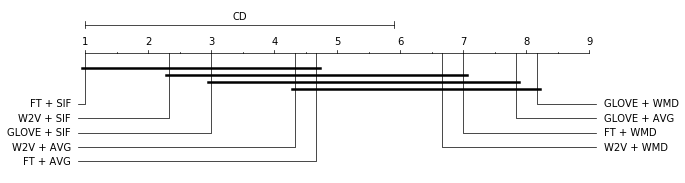

In [38]:
graph_ranks(avg_ranks, list(sts12_pearson.keys()), cd=cd_nemenyi, width=9, textspace=1)
plt.show()

### Bonferroni-Dunn test

Since the *FT + SIF* method has obtained the first position for all data sets, it seems reasonable to use the Bonferroni-Dunn test to compare this method with the others. The Bonferroni-Dunn test is also based on the calculation of a critical distance whose expression is very similar to the Nemenyi critical distance. Considering a confidence level of 95%, α= 0.05, and knowing that the number of methods is *K=9* and the number of data sets is *N=6*, the calculated Bonferroni-Dunn critical distance is:

In [3]:
cd_bonferroni_dunn = compute_CD(avg_ranks, N, alpha='0.05', test='bonferroni-dunn') 
print("Bonferroni-Dunn critical distance (alpha = 0.05) = ", cd_bonferroni_dunn)

Bonferroni-Dunn critical distance (alpha = 0.05) = 4.3070


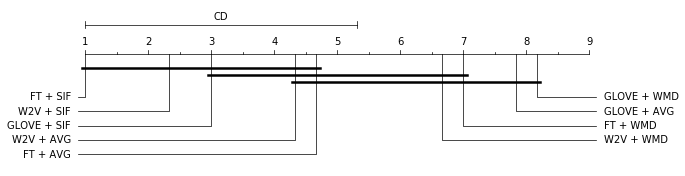

In [40]:
graph_ranks(avg_ranks, list(sts12_pearson.keys()), cd=cd_bonferroni_dunn, width=9, textspace=1)
plt.show()


The critical distance of the Bonferroni-Dunn test is **4.3070**. Selecting the *FT + SIF* method as the control method, it is found that this method is significantly better than *W2V + WMD*, *FT + WMD*, *GLOVE + WMD* and *GLOVE + AVG*.

## Conclusions

1. Combining FastText's pre-trained word vectors by performing a SIF average is the most accurate method for measuring semantic similarity between pairs of documents.
   

2. Among the evaluated pre-trained vector sets, it can be observed that the GloVe set performs worse than the Word2Vec or FastText sets, regardless of the method used to calculate semantic similarity.

    
3. Although performing an unweighted average of the word vectors is a good starting point to obtain a vector of a sentence, applying a SIF (Smooth Inverse Frequency) weighting is a better alternative. 
   


4. Among the possibilities to measure similarity, the inverse of the distance *Word Mover's Distance* as a measure gives the worst results.